In [1]:
import sys
sys.path.insert(0, "../")

import os
import operator
import logging as logger
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from astropy.table import Table
from tqdm import tqdm
from time import time

from mcfa.mcfa import MCFA

%matplotlib inline

In [2]:
SEED = 42

In [3]:
galah = Table.read("../catalogs/GALAH_DR2.1_catalog.fits")

In [4]:
np.random.seed(SEED)

# Get some subset of the data
N = 1000 # subsample the data for testing

D = 15
element_label_names = [ln for ln in galah.dtype.names if ln.endswith("_fe") and not ln.startswith(("flag_", "e_", "alpha_"))]

# Select a subset of stars and abundances
is_ok = dict()
for label_name in element_label_names:
    is_ok[label_name] = sum(galah["flag_{}".format(label_name)] == 0)
    
use_element_label_names = [k for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]][:D - 1]

# Add in Eu.
use_element_label_names.append("eu_fe")

meets_qc = (galah["flag_cannon"] == 0)
print(sum(meets_qc))
for label_name in use_element_label_names:
    meets_qc *= (galah["flag_{}".format(label_name)] == 0) \
              * (np.isfinite(galah[label_name]))
    
use_element_label_names.append("fe_h")
    


X = np.array([galah[ln][meets_qc] for ln in use_element_label_names]).T

if N is not None and N < X.shape[0]:    
    print("Sub-sampling {} stars (from {})".format(N, X.shape[0]))
    idx = np.random.choice(X.shape[0], N, replace=False)
    X = X[idx]

else:
    idx = np.arange(sum(meets_qc))

fe_h_index = list(use_element_label_names).index("fe_h")
for d in range(D):
    if d == fe_h_index: continue
    X[:, d] += X[:, fe_h_index]
    
    
label_names = np.array(["{}_h".format(ea.split("_")[0]) for ea in use_element_label_names])
    
N, D = X.shape
assert N > D
assert np.all(np.isfinite(X))

264227
Sub-sampling 1000 stars (from 7984)


In [5]:
# Do things in linear abundance.
X = 10**X

In [6]:
# Do some grid search in J, K
Js = np.arange(1, 5 + 1).astype(int)
Ks = np.arange(1, 50 + 1).astype(int)

# TODO: Should we use some approximation to estimate how long it will take?

BICs = np.nan * np.ones((Js.size, Ks.size))
opt_times = np.nan * np.ones((Js.size, Ks.size))
log_likelihoods = np.nan * np.ones((Js.size, Ks.size))

write_results = True
results_path = "results/galah-gridsearch-J{J}-K{K}.pkl"

results_folder = os.path.dirname(results_path)
if not os.path.exists(results_folder):
    os.mkdir(results_folder)

mcfa_kwds = dict(max_iter=500, n_init=5, tol=1e-5, verbose=0,
                 random_seed=SEED)

In [7]:
c, C = (0, Js.size * Ks.size)

for j, J in enumerate(Js):
    for k, K in enumerate(Ks):
        
        c += 1
        print("{}/{}: J = {}, K = {}".format(c, C, J, K))
        if np.isfinite(BICs[j, k]):
            print("Skipping..")
            continue
        
        kwds = mcfa_kwds.copy()
        kwds.update(n_components=K, n_latent_factors=J)
        
        model = MCFA(**kwds)
        
        t_init = time()
        try:
            model.fit(X)
            
        except:
            logger.exception("Exception in fitting at J = {}, K = {}".format(J, K))
            opt_times[j, k] = np.nan
            BICs[j, k] = np.nan
            log_likelihoods[j, k] = np.nan
            continue
            
        t_opt = time() - t_init
        
        # Save results.
        opt_times[j, k] = t_opt
        BICs[j, k] = model.bic(X)
        log_likelihoods[j, k] = model.log_likelihood_                     
        
        if write_results:
            result = dict(kwds=kwds,
                          t_opt=t_opt,
                          bic=BICs[j, k],
                          tau=model.tau_,
                          theta=model.theta_,
                          n_iter=model.n_iter_, 
                          log_likelihood=model.log_likelihood_)
            
            path = results_path.format(J=J, K=K)
            with open(path, "wb") as fp:
                pickle.dump(result, fp, -1)

            print("Results written to {}".format(path))



1/250: J = 1, K = 1
Results written to results/galah-gridsearch-J1-K1.pkl
2/250: J = 1, K = 2
Results written to results/galah-gridsearch-J1-K2.pkl
3/250: J = 1, K = 3
Results written to results/galah-gridsearch-J1-K3.pkl
4/250: J = 1, K = 4
Results written to results/galah-gridsearch-J1-K4.pkl
5/250: J = 1, K = 5
Results written to results/galah-gridsearch-J1-K5.pkl
6/250: J = 1, K = 6
Results written to results/galah-gridsearch-J1-K6.pkl
7/250: J = 1, K = 7
Results written to results/galah-gridsearch-J1-K7.pkl
8/250: J = 1, K = 8
Results written to results/galah-gridsearch-J1-K8.pkl
9/250: J = 1, K = 9
Results written to results/galah-gridsearch-J1-K9.pkl
10/250: J = 1, K = 10
Results written to results/galah-gridsearch-J1-K10.pkl
11/250: J = 1, K = 11
Results written to results/galah-gridsearch-J1-K11.pkl
12/250: J = 1, K = 12
Results written to results/galah-gridsearch-J1-K12.pkl
13/250: J = 1, K = 13
Results written to results/galah-gridsearch-J1-K13.pkl
14/250: J = 1, K = 14
Resu

../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K32.pkl
33/250: J = 1, K = 33
Results written to results/galah-gridsearch-J1-K33.pkl
34/250: J = 1, K = 34
Results written to results/galah-gridsearch-J1-K34.pkl
35/250: J = 1, K = 35
Results written to results/galah-gridsearch-J1-K35.pkl
36/250: J = 1, K = 36


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K36.pkl
37/250: J = 1, K = 37


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K37.pkl
38/250: J = 1, K = 38
Results written to results/galah-gridsearch-J1-K38.pkl
39/250: J = 1, K = 39


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K39.pkl
40/250: J = 1, K = 40


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K40.pkl
41/250: J = 1, K = 41


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K41.pkl
42/250: J = 1, K = 42


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K42.pkl
43/250: J = 1, K = 43


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K43.pkl
44/250: J = 1, K = 44


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K44.pkl
45/250: J = 1, K = 45


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K45.pkl
46/250: J = 1, K = 46


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K46.pkl
47/250: J = 1, K = 47


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

Results written to results/galah-gridsearch-J1-K47.pkl
48/250: J = 1, K = 48


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J1-K48.pkl
49/250: J = 1, K = 49


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

Results written to results/galah-gridsearch-J1-K49.pkl
50/250: J = 1, K = 50


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

Results written to results/galah-gridsearch-J1-K50.pkl
51/250: J = 2, K = 1
Results written to results/galah-gridsearch-J2-K1.pkl
52/250: J = 2, K = 2
Results written to results/galah-gridsearch-J2-K2.pkl
53/250: J = 2, K = 3
Results written to results/galah-gridsearch-J2-K3.pkl
54/250: J = 2, K = 4
Results written to results/galah-gridsearch-J2-K4.pkl
55/250: J = 2, K = 5
Results written to results/galah-gridsearch-J2-K5.pkl
56/250: J = 2, K = 6
Results written to results/galah-gridsearch-J2-K6.pkl
57/250: J = 2, K = 7
Results written to results/galah-gridsearch-J2-K7.pkl
58/250: J = 2, K = 8
Results written to results/galah-gridsearch-J2-K8.pkl
59/250: J = 2, K = 9
Results written to results/galah-gridsearch-J2-K9.pkl
60/250: J = 2, K = 10
Results written to results/galah-gridsearch-J2-K10.pkl
61/250: J = 2, K = 11
Results written to results/galah-gridsearch-J2-K11.pkl
62/250: J = 2, K = 12
Results written to results/galah-gridsearch-J2-K12.pkl
63/250: J = 2, K = 13
Results written t

../mcfa/mcfa.py:264: RuntimeWarning: divide by zero encountered in log
  weighted_log_prob = log_prob + np.log(pi)
../mcfa/mcfa.py:346: RuntimeWarning: invalid value encountered in true_divide
  xi[:, i] += gamma.T @ (np.sum(tY_Axi_i, axis=1) / ti[i])
../mcfa/mcfa.py:352: RuntimeWarning: invalid value encountered in true_divide
  - diff @ diff.T
ERROR:root:Exception in fitting at J = 2, K = 29
Traceback (most recent call last):
  File "<ipython-input-7-ca681d729218>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fit
    theta = self.maximization(X, tau, *theta)
  File "../mcfa/mcfa.py", line 359, in maximization
    A = A1 @ linalg.solve(A2, I_J)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 139, in solve
    a1 = atleast_2d(_asarray_validated(a, check_finite=check_finite))
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/_lib/_util.py", line 238, in _asarray_validated
    a = toarray(a)
  Fil

80/250: J = 2, K = 30
Results written to results/galah-gridsearch-J2-K30.pkl
81/250: J = 2, K = 31
Results written to results/galah-gridsearch-J2-K31.pkl
82/250: J = 2, K = 32


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J2-K32.pkl
83/250: J = 2, K = 33


../mcfa/mcfa.py:264: RuntimeWarning: divide by zero encountered in log
  weighted_log_prob = log_prob + np.log(pi)
../mcfa/mcfa.py:346: RuntimeWarning: invalid value encountered in true_divide
  xi[:, i] += gamma.T @ (np.sum(tY_Axi_i, axis=1) / ti[i])
../mcfa/mcfa.py:352: RuntimeWarning: invalid value encountered in true_divide
  - diff @ diff.T
ERROR:root:Exception in fitting at J = 2, K = 33
Traceback (most recent call last):
  File "<ipython-input-7-ca681d729218>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fit
    theta = self.maximization(X, tau, *theta)
  File "../mcfa/mcfa.py", line 359, in maximization
    A = A1 @ linalg.solve(A2, I_J)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 139, in solve
    a1 = atleast_2d(_asarray_validated(a, check_finite=check_finite))
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/_lib/_util.py", line 238, in _asarray_validated
    a = toarray(a)
  Fil

84/250: J = 2, K = 34
Results written to results/galah-gridsearch-J2-K34.pkl
85/250: J = 2, K = 35


../mcfa/mcfa.py:264: RuntimeWarning: divide by zero encountered in log
  weighted_log_prob = log_prob + np.log(pi)
../mcfa/mcfa.py:346: RuntimeWarning: invalid value encountered in true_divide
  xi[:, i] += gamma.T @ (np.sum(tY_Axi_i, axis=1) / ti[i])
../mcfa/mcfa.py:352: RuntimeWarning: invalid value encountered in true_divide
  - diff @ diff.T
ERROR:root:Exception in fitting at J = 2, K = 35
Traceback (most recent call last):
  File "<ipython-input-7-ca681d729218>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fit
    theta = self.maximization(X, tau, *theta)
  File "../mcfa/mcfa.py", line 359, in maximization
    A = A1 @ linalg.solve(A2, I_J)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 139, in solve
    a1 = atleast_2d(_asarray_validated(a, check_finite=check_finite))
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/_lib/_util.py", line 238, in _asarray_validated
    a = toarray(a)
  Fil

86/250: J = 2, K = 36


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.654561e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.823527e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)


Results written to results/galah-gridsearch-J2-K36.pkl
87/250: J = 2, K = 37


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.000912e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.082767e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.004922e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.603805e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.267888e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.043711e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.853390

88/250: J = 2, K = 38


../mcfa/mcfa.py:264: RuntimeWarning: divide by zero encountered in log
  weighted_log_prob = log_prob + np.log(pi)
../mcfa/mcfa.py:346: RuntimeWarning: invalid value encountered in true_divide
  xi[:, i] += gamma.T @ (np.sum(tY_Axi_i, axis=1) / ti[i])
../mcfa/mcfa.py:352: RuntimeWarning: invalid value encountered in true_divide
  - diff @ diff.T
ERROR:root:Exception in fitting at J = 2, K = 38
Traceback (most recent call last):
  File "<ipython-input-7-ca681d729218>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fit
    theta = self.maximization(X, tau, *theta)
  File "../mcfa/mcfa.py", line 359, in maximization
    A = A1 @ linalg.solve(A2, I_J)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 139, in solve
    a1 = atleast_2d(_asarray_validated(a, check_finite=check_finite))
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/_lib/_util.py", line 238, in _asarray_validated
    a = toarray(a)
  Fil

89/250: J = 2, K = 39


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J2-K39.pkl
90/250: J = 2, K = 40


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.159366e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:264: RuntimeWarning: divide by zero encountered in log
  weighted_log_prob = log_prob + np.log(pi)
../mcfa/mcfa.py:346: RuntimeWarning: invalid value encountered in true_divide
  xi[:, i] += gamma.T @ (np.sum(tY_Axi_i, axis=1) / ti[i])
../mcfa/mcfa.py:352: RuntimeWarning: invalid value encountered in true_divide
  - diff @ di

91/250: J = 2, K = 41


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.251830e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/f

Results written to results/galah-gridsearch-J2-K41.pkl
92/250: J = 2, K = 42


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:346: RuntimeWarning: invalid value encountered in true_divide
  xi[:, i] += gamma.T @ (n

93/250: J = 2, K = 43


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:264: RuntimeWarning: divide by zero encountered in log
  weighted_log_prob = log_prob + np.log(pi)
../mcfa/mcfa.py:346: RuntimeWarning: invalid value encountered in true_divide
  xi[:, i] += gamma.T @ (np.sum(tY_Axi_i, axis=1) / ti[i])
../mcfa/mcfa.py:352: RuntimeWarning: invalid value encountered in true_divide
  - diff @ diff.T
ERROR:root:Exception in fitting at J = 2, K = 43
Traceback (most recent call last):
  File "<ipython-input-7-ca681d729218>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fi

94/250: J = 2, K = 44


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.130912e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.436971e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Re

95/250: J = 2, K = 45


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J2-K45.pkl
96/250: J = 2, K = 46


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.159366e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/f

97/250: J = 2, K = 47


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

98/250: J = 2, K = 48


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.331674e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.000912e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

99/250: J = 2, K = 49


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not gu

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.671788e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.529408e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.280288e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.025207e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.213529e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.521006e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.360464e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.815124e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.908721e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.563018e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.386780e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.941169e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.

100/250: J = 2, K = 50


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

Results written to results/galah-gridsearch-J2-K50.pkl
101/250: J = 3, K = 1
Results written to results/galah-gridsearch-J3-K1.pkl
102/250: J = 3, K = 2
Results written to results/galah-gridsearch-J3-K2.pkl
103/250: J = 3, K = 3
Results written to results/galah-gridsearch-J3-K3.pkl
104/250: J = 3, K = 4
Results written to results/galah-gridsearch-J3-K4.pkl
105/250: J = 3, K = 5
Results written to results/galah-gridsearch-J3-K5.pkl
106/250: J = 3, K = 6
Results written to results/galah-gridsearch-J3-K6.pkl
107/250: J = 3, K = 7
Results written to results/galah-gridsearch-J3-K7.pkl
108/250: J = 3, K = 8
Results written to results/galah-gridsearch-J3-K8.pkl
109/250: J = 3, K = 9
Results written to results/galah-gridsearch-J3-K9.pkl
110/250: J = 3, K = 10
Results written to results/galah-gridsearch-J3-K10.pkl
111/250: J = 3, K = 11
Results written to results/galah-gridsearch-J3-K11.pkl
112/250: J = 3, K = 12
Results written to results/galah-gridsearch-J3-K12.pkl
113/250: J = 3, K = 13
Resu

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.488210e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 3, K = 27
Traceback (most recent call last):
  File "<ipython-input-7-ca681d729218>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fit
    theta = self.maximization(X, tau, *theta)
  File "../mcfa/mcfa.py", line 337, in maximization
    W = linalg.solve(omega[:, :, i], I_J)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 216, in solve
    _solve_check(n, info)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 31, in _solve_check
    raise LinAlgError('Matrix is singular.')
numpy.linalg.linalg.LinAlgError: Matrix is singular.


128/250: J = 3, K = 28
Results written to results/galah-gridsearch-J3-K28.pkl
129/250: J = 3, K = 29
Results written to results/galah-gridsearch-J3-K29.pkl
130/250: J = 3, K = 30
Results written to results/galah-gridsearch-J3-K30.pkl
131/250: J = 3, K = 31


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.652427e-18
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J3-K31.pkl
132/250: J = 3, K = 32


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J3-K32.pkl
133/250: J = 3, K = 33
Results written to results/galah-gridsearch-J3-K33.pkl
134/250: J = 3, K = 34


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.695728e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.038962e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 3, K = 34
Traceback (most recent call last):
  File "<ipython-input-7-ca681d729218>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fit
    theta = self.maximization(X, tau, *theta)
  File "../mcfa/mcfa.py", line 337, in maximization
    W = linalg.solve(omega[:, :, i], I_J)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 216, in solve
    _solve_check(n, info)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 31, in _solve_ch

135/250: J = 3, K = 35


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.652427e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.402880e-18
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J3-K35.pkl
136/250: J = 3, K = 36


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.130485e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.154378e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

137/250: J = 3, K = 37


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.191059e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.652427e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.652427e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeW

Results written to results/galah-gridsearch-J3-K37.pkl
138/250: J = 3, K = 38


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.130485e-17
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J3-K38.pkl
139/250: J = 3, K = 39


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Results written to results/galah-gridsearch-J3-K39.pkl
140/250: J = 3, K = 40


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.920864e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.350783e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

141/250: J = 3, K = 41


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.652427e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/f

142/250: J = 3, K = 42


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.130485e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/f

Results written to results/galah-gridsearch-J3-K42.pkl
143/250: J = 3, K = 43


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.214918e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.377614e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

144/250: J = 3, K = 44


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.308273e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.716460e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.652427e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: Runti

145/250: J = 3, K = 45


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.004397e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.488210e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.652427e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeW

146/250: J = 3, K = 46


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.350783e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.652427e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

147/250: J = 3, K = 47


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

148/250: J = 3, K = 48


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.581940e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.652427e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/py

149/250: J = 3, K = 49


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

150/250: J = 3, K = 50


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.628654e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.054357e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.695728e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.130485e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.402880

151/250: J = 4, K = 1
Results written to results/galah-gridsearch-J4-K1.pkl
152/250: J = 4, K = 2
Results written to results/galah-gridsearch-J4-K2.pkl
153/250: J = 4, K = 3
Results written to results/galah-gridsearch-J4-K3.pkl
154/250: J = 4, K = 4
Results written to results/galah-gridsearch-J4-K4.pkl
155/250: J = 4, K = 5
Results written to results/galah-gridsearch-J4-K5.pkl
156/250: J = 4, K = 6
Results written to results/galah-gridsearch-J4-K6.pkl
157/250: J = 4, K = 7
Results written to results/galah-gridsearch-J4-K7.pkl
158/250: J = 4, K = 8
Results written to results/galah-gridsearch-J4-K8.pkl
159/250: J = 4, K = 9
Results written to results/galah-gridsearch-J4-K9.pkl
160/250: J = 4, K = 10
Results written to results/galah-gridsearch-J4-K10.pkl
161/250: J = 4, K = 11
Results written to results/galah-gridsearch-J4-K11.pkl
162/250: J = 4, K = 12
Results written to results/galah-gridsearch-J4-K12.pkl
163/250: J = 4, K = 13
Results written to results/galah-gridsearch-J4-K13.pkl
164/

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.124096e-18
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 4, K = 21
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_precision_cholesky_full
    cholesky_cov = linalg.cholesky(cov, lower=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 40, in _cholesky
    "definite" % info)
numpy.linalg.linalg.LinAlgError: 14-th leading minor of the array is not positive defin

172/250: J = 4, K = 22
Results written to results/galah-gridsearch-J4-K22.pkl
173/250: J = 4, K = 23
Results written to results/galah-gridsearch-J4-K23.pkl
174/250: J = 4, K = 24
Results written to results/galah-gridsearch-J4-K24.pkl
175/250: J = 4, K = 25
Results written to results/galah-gridsearch-J4-K25.pkl
176/250: J = 4, K = 26


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.060814e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.293175e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.192664e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.685939

177/250: J = 4, K = 27


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.587130e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.272792e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.544411e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.248193e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.377005

../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.330485e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.215043e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.939254e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.168218e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.611025

178/250: J = 4, K = 28


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.062048e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.544411e-18
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J4-K28.pkl
179/250: J = 4, K = 29


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.544411e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.718096e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 4, K = 29
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_precision_cholesky_full
    cholesky_cov = linalg.cholesky(cov, lower=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 40, in _cholesky
    "definite" % info)
numpy.linalg.linalg.LinAlgError: 10-th leading minor of the array is not positive defin

180/250: J = 4, K = 30


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.516849e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.062048e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.331337e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.372289e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.849508

181/250: J = 4, K = 31


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.012163e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.032117e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 4, K = 31
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_precision_cholesky_full
    cholesky_cov = linalg.cholesky(cov, lower=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/home/acas

182/250: J = 4, K = 32


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.012163e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.048651e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

183/250: J = 4, K = 33


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.840754e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.124096e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.248193e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.124096

184/250: J = 4, K = 34


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.041152e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.012163e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 4, K = 34
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_precision_cholesky_full
    cholesky_cov = linalg.cholesky(cov, lower=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 40, in _cholesky
    "definite" % info)
numpy.linalg.linalg.LinAlgError: 14-th leading minor of the array is not positive defin

185/250: J = 4, K = 35


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.349560e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.085140e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.409680

186/250: J = 4, K = 36


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.041152e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.521325e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

187/250: J = 4, K = 37


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.575812e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.349560e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.161760e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.048651e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/li

188/250: J = 4, K = 38


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.372289e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.767743e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.103213e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 4, K = 38
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_precision_cholesky_full
    cholesky_cov = linalg.cholesky(cov, lower=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/home/acas

189/250: J = 4, K = 39


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.012163e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.950585e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

190/250: J = 4, K = 40


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.201204e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.544411e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.062048e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.774393e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/li

191/250: J = 4, K = 41


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.000938e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.544411e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

192/250: J = 4, K = 42


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.349560e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.093737e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/li

193/250: J = 4, K = 43


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.101575e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.036489e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

194/250: J = 4, K = 44


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.048651e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.496385e-18
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 4, K = 44
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_pr

195/250: J = 4, K = 45


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024326e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
ERROR:root:Exception in fitting at J = 4, K = 45
Traceback (most recent call last):
  File "<ipython-input-7-ca681d729218>", line 19, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 410, in fit
    theta = self._initial_parameters(X) if init_params is None \
  File "../mcfa/mcfa.py", line 151, in _initial_parameters
    raise Val

196/250: J = 4, K = 46


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.427457e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.508097e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

197/250: J = 4, K = 47


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

198/250: J = 4, K = 48


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
ERROR:root:Exception in fitting at J = 4, K = 48
Traceback (most recent call last):
  File "<ipython-inp

199/250: J = 4, K = 49


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not gu

200/250: J = 4, K = 50


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.940322e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.544411e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.082304e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeW

201/250: J = 5, K = 1
Results written to results/galah-gridsearch-J5-K1.pkl
202/250: J = 5, K = 2
Results written to results/galah-gridsearch-J5-K2.pkl
203/250: J = 5, K = 3
Results written to results/galah-gridsearch-J5-K3.pkl
204/250: J = 5, K = 4
Results written to results/galah-gridsearch-J5-K4.pkl
205/250: J = 5, K = 5
Results written to results/galah-gridsearch-J5-K5.pkl
206/250: J = 5, K = 6
Results written to results/galah-gridsearch-J5-K6.pkl
207/250: J = 5, K = 7
Results written to results/galah-gridsearch-J5-K7.pkl
208/250: J = 5, K = 8
Results written to results/galah-gridsearch-J5-K8.pkl
209/250: J = 5, K = 9
Results written to results/galah-gridsearch-J5-K9.pkl
210/250: J = 5, K = 10


Results written to results/galah-gridsearch-J5-K10.pkl
211/250: J = 5, K = 11
Results written to results/galah-gridsearch-J5-K11.pkl
212/250: J = 5, K = 12


Results written to results/galah-gridsearch-J5-K12.pkl
213/250: J = 5, K = 13


Results written to results/galah-gridsearch-J5-K13.pkl
214/250: J = 5, K = 14
Results written to results/galah-gridsearch-J5-K14.pkl
215/250: J = 5, K = 15
Results written to results/galah-gridsearch-J5-K15.pkl
216/250: J = 5, K = 16
Results written to results/galah-gridsearch-J5-K16.pkl
217/250: J = 5, K = 17
Results written to results/galah-gridsearch-J5-K17.pkl
218/250: J = 5, K = 18
Results written to results/galah-gridsearch-J5-K18.pkl
219/250: J = 5, K = 19
Results written to results/galah-gridsearch-J5-K19.pkl
220/250: J = 5, K = 20
Results written to results/galah-gridsearch-J5-K20.pkl
221/250: J = 5, K = 21


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.245944e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.671820e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.388205e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 5, K = 21
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_precision_cholesky_full
    cholesky_cov = linalg.cholesky(cov, lower=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/home/acas

222/250: J = 5, K = 22


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.453690e-17
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J5-K22.pkl
223/250: J = 5, K = 23


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.426554e-17
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J5-K23.pkl
224/250: J = 5, K = 24


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.218884e-17
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J5-K24.pkl
225/250: J = 5, K = 25


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.740880e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.799667e-17
  W = linalg.solve(omega[:, :, i], I_J)


Results written to results/galah-gridsearch-J5-K25.pkl
226/250: J = 5, K = 26


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.207657e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.057430e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.414839e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 5, K = 26
Traceback (most recent call last):
  File "../mcfa/mcfa.py", line 663, in _compute_precision_cholesky_full
    cholesky_cov = linalg.cholesky(cov, lower=True)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/home/acas

227/250: J = 5, K = 27


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.008303e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.115050e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.853637e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.059543e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.180535

228/250: J = 5, K = 28


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.011207e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.225520e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.907380e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.462456e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.011215

229/250: J = 5, K = 29


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.215203e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.245327e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.661360e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.408152e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.574113

230/250: J = 5, K = 30


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.123629e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.127759e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.345149e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.297714e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.933560

231/250: J = 5, K = 31


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.629125e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.327990e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.644609e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.792524e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.115

232/250: J = 5, K = 32


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.999278e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.953903e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.902280e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.134361e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/li

233/250: J = 5, K = 33


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.671654e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.981594e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.735282e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.055762e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.038

234/250: J = 5, K = 34


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.051019e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.543997e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.273700e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.135158e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.

235/250: J = 5, K = 35


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.553903e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.341273e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.306114e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.293655e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.557

236/250: J = 5, K = 36


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.910266e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.076700e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

237/250: J = 5, K = 37


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.381412e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.916698e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.824512e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.097308e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.289528

238/250: J = 5, K = 38


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.998557e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.306114e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.236997e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.603407e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.617

239/250: J = 5, K = 39


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.083044e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.345149e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

240/250: J = 5, K = 40


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.080482e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.623444e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.785496e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.102038e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.729981

241/250: J = 5, K = 41


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.018821e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.345149e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

242/250: J = 5, K = 42


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.259398e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.124907e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.102038e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.132708e-18
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.567

243/250: J = 5, K = 43


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.672806e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.751956e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

244/250: J = 5, K = 44


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.681577e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.998557e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

245/250: J = 5, K = 45


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.485235e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.751071e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.762611e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.134634e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.817

246/250: J = 5, K = 46


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.519702e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.683040e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Re

247/250: J = 5, K = 47


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

248/250: J = 5, K = 48


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.340529e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.306114e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

249/250: J = 5, K = 49


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/

250/250: J = 5, K = 50


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.232393e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.595389e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib

In [8]:
def scatter_grid_search(Js, Ks, Zs, z_percentiles=None, cbar_label=None,
                        figsize=(10, 10), highlight_z_index=None, **kwargs):

    Jm, Km = np.meshgrid(Js, Ks)
    x, y = (Jm.flatten(), Km.flatten())
    z = Zs.T.flatten()

    kwds = dict(s=10, cmap="viridis")
    if z_percentiles is not None:
        vmin, vmax = np.nanpercentile(z, z_percentiles)
        kwds.update(vmin=vmin, vmax=vmax)
    
    kwds.update(kwargs)
    
    fig, ax = plt.subplots(figsize=figsize)
    scat = ax.scatter(x, y, c=z, **kwds)
    
    ax.set_xlabel(r"$J$")
    ax.set_ylabel(r"$K$")
    
    if cbar_label is not None:
        cbar = plt.colorbar(scat)
        cbar.set_label(cbar_label)
        
    ax.set_xticks(np.unique(x).astype(int))
    ax.set_xticklabels(np.unique(x).astype(str))
    
    if highlight_z_index is not None:
        ok = np.where(np.isfinite(z))[0]
        
        indices = ok[np.argsort(z[ok])][highlight_z_index]
        ax.scatter(x[indices], y[indices], zorder=-1,
                   s=100, lw=5, edgecolor="r", facecolor="none")
        
    
    fig.tight_layout()
    return fig


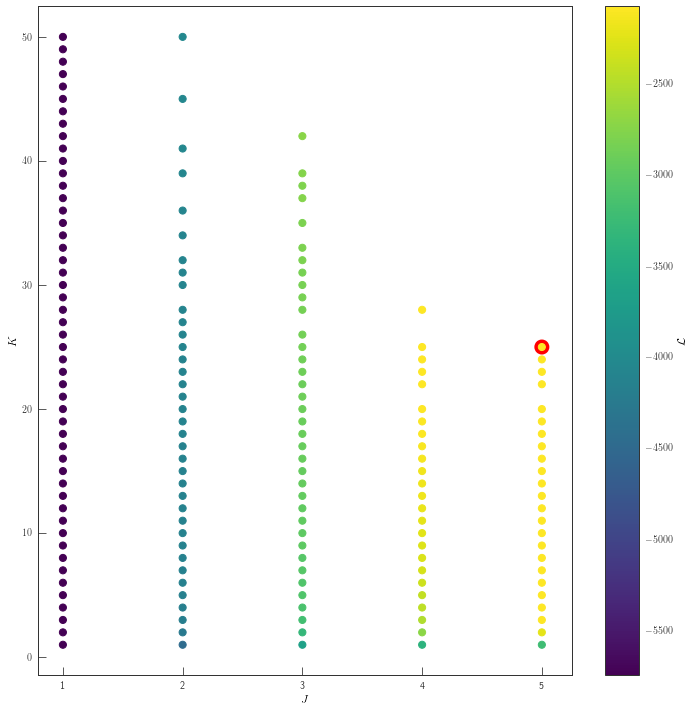

In [9]:
fig = scatter_grid_search(Js, Ks, log_likelihoods, s=50,
                          z_percentiles=[16, 84], cbar_label=r"$\mathcal{L}$",
                          highlight_z_index=-1)

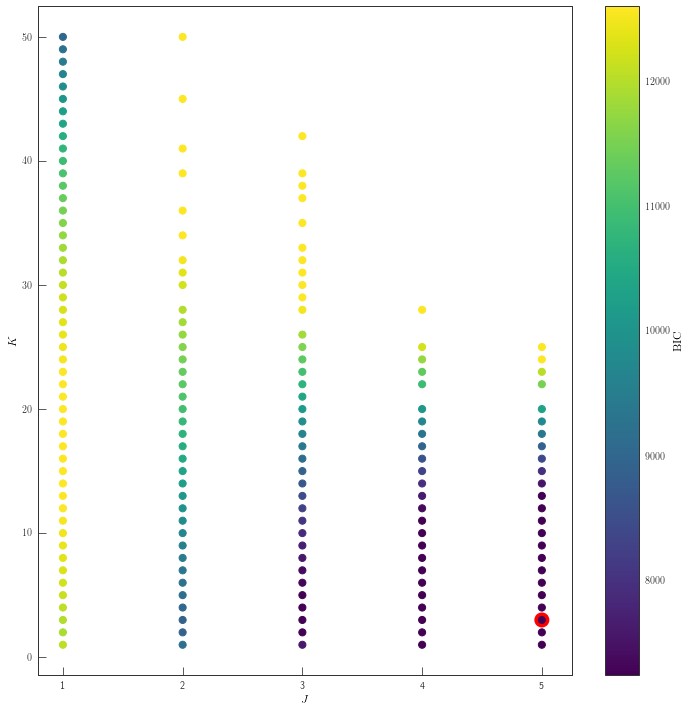

In [10]:
fig = scatter_grid_search(Js, Ks, BICs, s=50,
                          z_percentiles=[16, 84], cbar_label=r"\textrm{BIC}",
                          highlight_z_index=0)

In [11]:
model = MCFA(n_components=2, n_latent_factors=5, **mcfa_kwds)

In [12]:
model.fit(X)

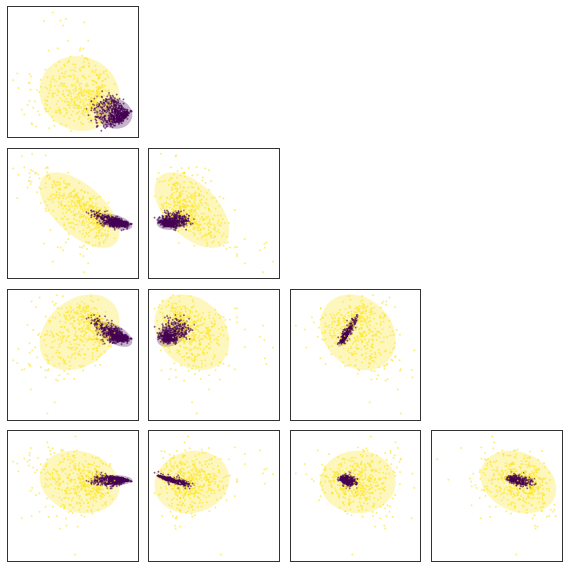

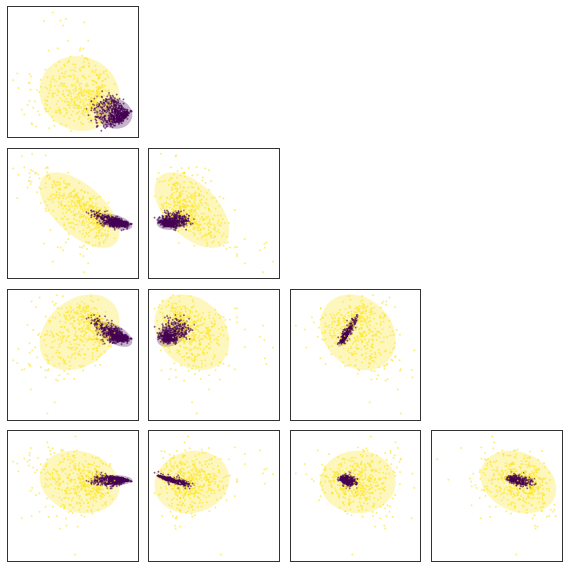

In [13]:
model.plot_latent_space(X)

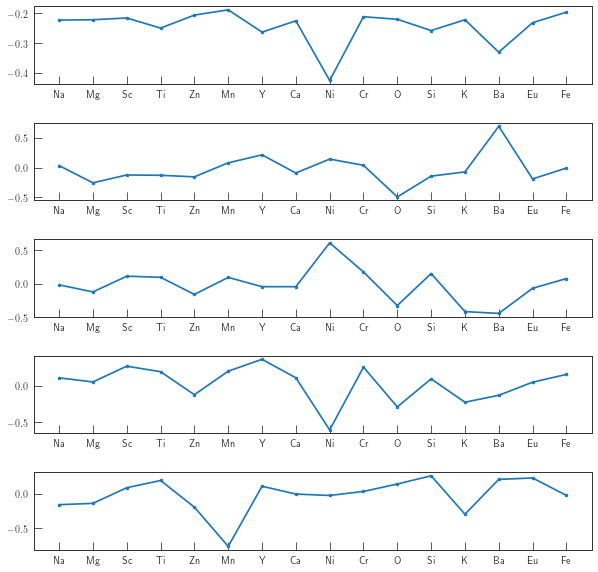

In [14]:
N, D = X.shape

latex_label_name = lambda ln: r"\textrm{{[{{{0}}}]}}".format("/".join([ln.split("_")[0].title(), ln.split("_")[1].upper()]))
latex_label_name = lambda ln: ln.split("_")[0].title()
                               
A = model.theta_[model.parameter_names.index("A")]
fig, axes = plt.subplots(model.n_latent_factors, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(A.T[i])
    ax.set_xticks(np.arange(D))
    ax.set_xticklabels([latex_label_name(ln) for ln in label_names])

In [15]:
# Group by "physics"
light_odd_z = ["Na", "K"]
fe_peak = ["Sc", "Cr", "Mn", "Fe", "Ni", "Zn"]
s_process = ["Y", "Ba"]
alpha = ["O", "Mg", "Si", "Ca", "Ti"]
r_process = ["Eu"]

ordered_label_names = light_odd_z \
                    + alpha \
                    + fe_peak \
                    + s_process \
                    + r_process

# ordered label indices
oli = np.array([list(label_names).index("{}_h".format(_.lower())) for _ in ordered_label_names])


assert len(set(ordered_label_names)) == len(set(label_names))



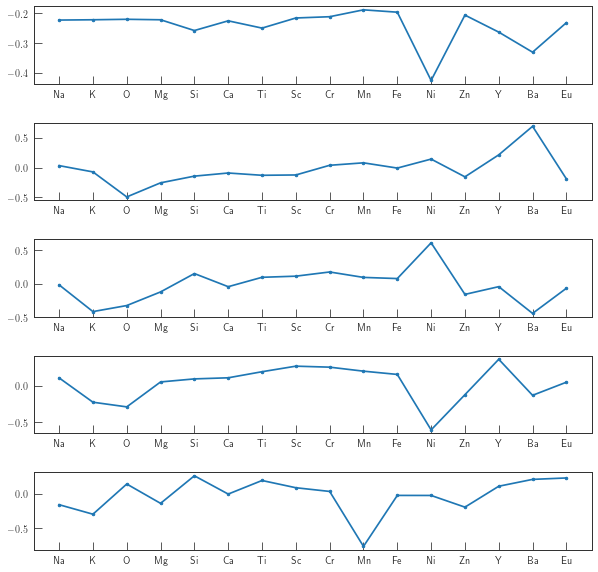

In [16]:

latex_label_name = lambda ln: ln.split("_")[0].title()
                               
A = model.theta_[model.parameter_names.index("A")]
fig, axes = plt.subplots(model.n_latent_factors, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(A.T[i][oli])
    ax.set_xticks(np.arange(D))
    ax.set_xticklabels([latex_label_name(label_names[_]) for _ in oli])
    

In [17]:
from mcfa import mpl_utils

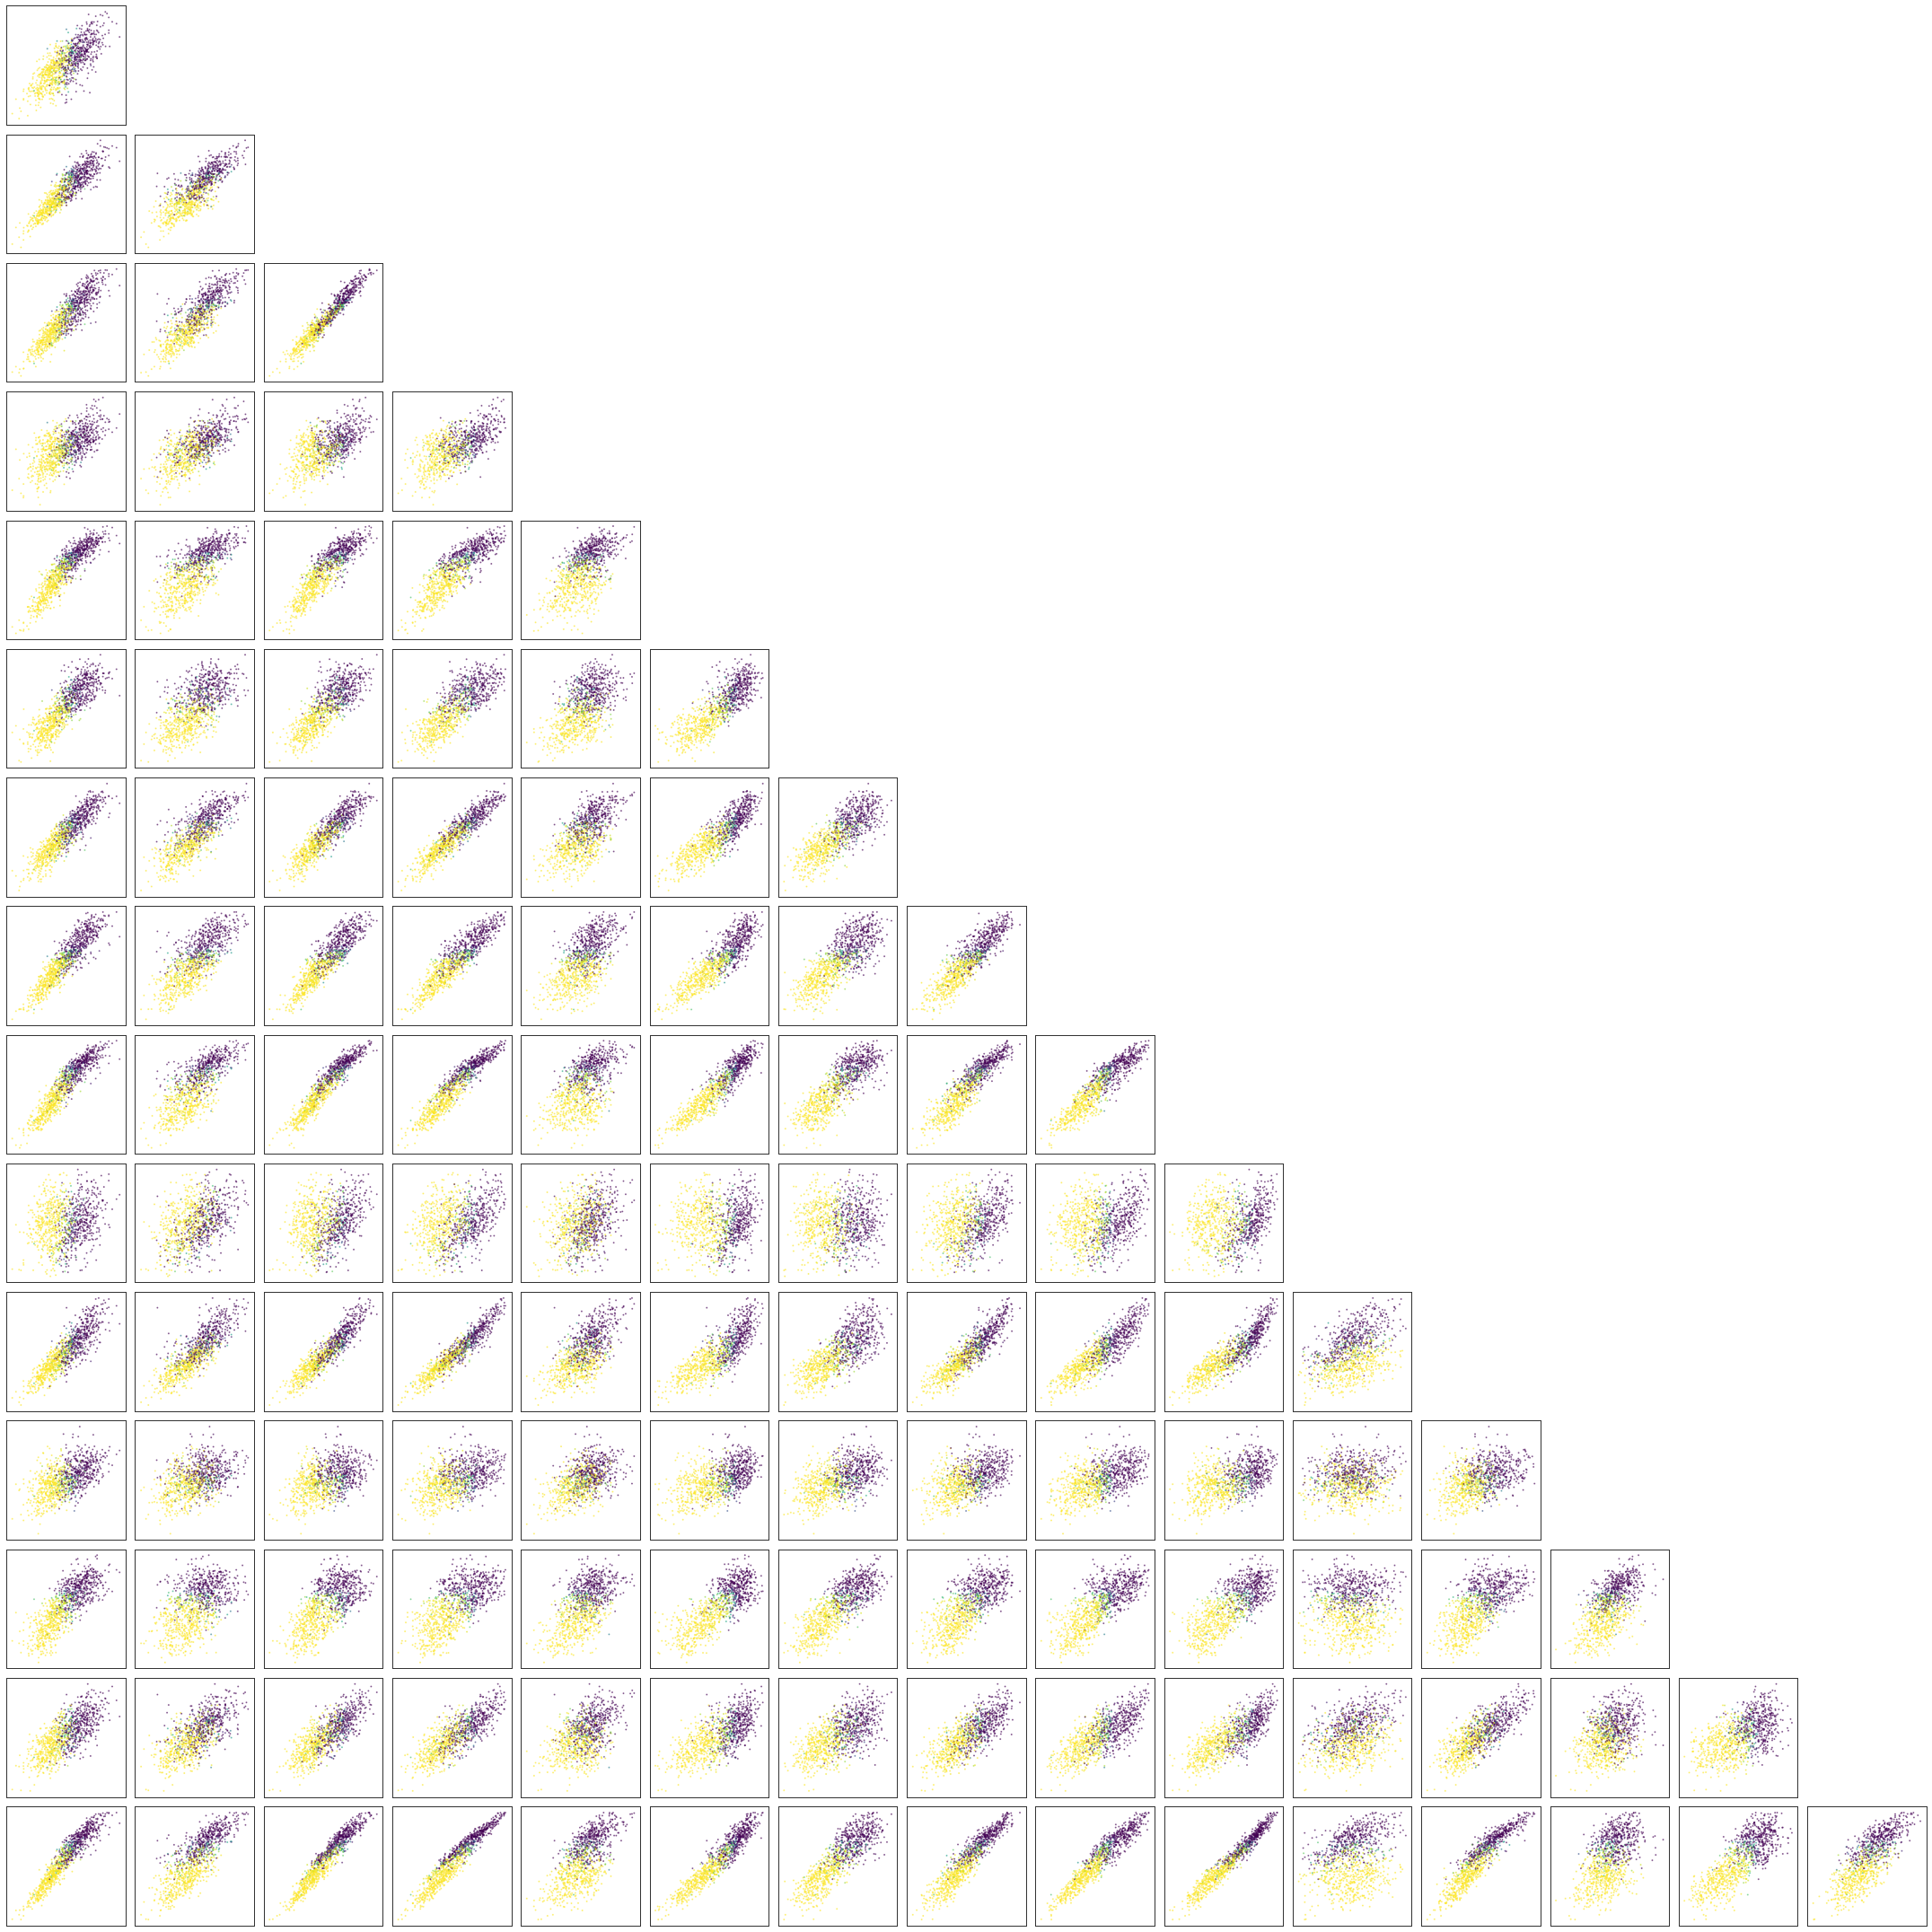

In [24]:
fig = mpl_utils.corner_scatter(np.log10(X[:, :]), c=model.tau_.T[0])

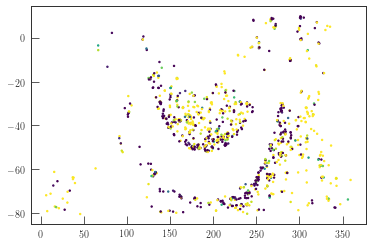

In [90]:
fig, ax = plt.subplots()
ax.scatter(galah["raj2000"][meets_qc][idx], galah["dej2000"][meets_qc][idx],
           c=model.tau_.T[0], s=2)

['na_h' 'mg_h' 'sc_h' 'ti_h' 'zn_h' 'mn_h' 'y_h' 'ca_h' 'ni_h' 'cr_h'
 'o_h' 'si_h' 'k_h' 'ba_h' 'eu_h' 'fe_h']


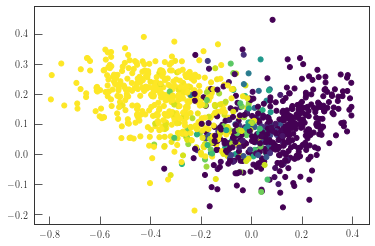

In [51]:
print(label_names)
abundance_ratio = lambda num, den="h": X.T[list(label_names).index("{}_h".format(num.lower()))] \
                                     / (1 if den.lower() == "h" else X.T[list(label_names).index("{}_h".format(den.lower()))])
log_abundance_ratio = lambda num, den="h": np.log10(abundance_ratio(num, den))
    
    
x = log_abundance_ratio("fe", "h")
y = log_abundance_ratio("si", "fe")
z = model.tau_.T[0]
           
fig, ax = plt.subplots()
ax.scatter(x, y, c=z)

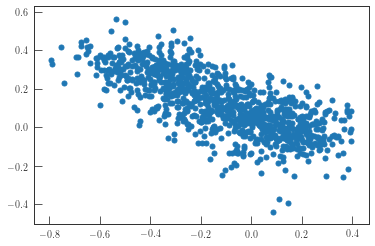

In [38]:
fig, ax = plt.subplots()
ax.scatter(np.log10(X.T[-1]), np.log10(X.T[1]) - np.log10(X.T[-1]))

In [53]:
model.parameter_names

('pi', 'A', 'xi', 'omega', 'psi')

25.0


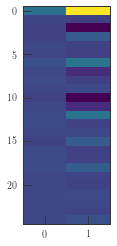

In [67]:
print(model.theta_[3].size/2)
fig, ax = plt.subplots()
ax.imshow(model.theta_[3].reshape(-1, 2), interpolation="nearest", aspect=1.0/5)

[Text(0,0,'Na'),
 Text(0,0,'Mg'),
 Text(0,0,'Sc'),
 Text(0,0,'Ti'),
 Text(0,0,'Zn'),
 Text(0,0,'Mn'),
 Text(0,0,'Y'),
 Text(0,0,'Ca'),
 Text(0,0,'Ni'),
 Text(0,0,'Cr'),
 Text(0,0,'O'),
 Text(0,0,'Si'),
 Text(0,0,'K'),
 Text(0,0,'Ba'),
 Text(0,0,'Eu'),
 Text(0,0,'Fe')]

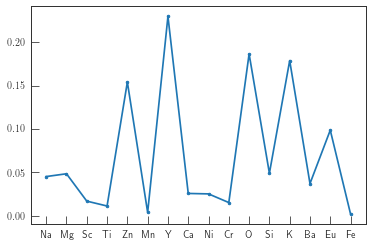

In [70]:
psi = model.theta_[model.parameter_names.index("psi")]
fig, ax = plt.subplots()
ax.plot(psi)
ax.set_xticks(np.arange(D))
ax.set_xticklabels([latex_label_name(ln) for ln in label_names])

[Text(0,0,'Na'),
 Text(0,0,'K'),
 Text(0,0,'O'),
 Text(0,0,'Mg'),
 Text(0,0,'Si'),
 Text(0,0,'Ca'),
 Text(0,0,'Ti'),
 Text(0,0,'Sc'),
 Text(0,0,'Cr'),
 Text(0,0,'Mn'),
 Text(0,0,'Fe'),
 Text(0,0,'Ni'),
 Text(0,0,'Zn'),
 Text(0,0,'Y'),
 Text(0,0,'Ba'),
 Text(0,0,'Eu')]

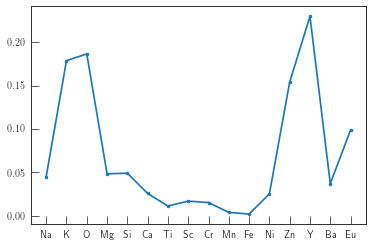

In [77]:
psi = model.theta_[model.parameter_names.index("psi")]
fig, ax = plt.subplots()
ax.plot(psi[oli])
ax.set_xticks(np.arange(D))
ax.set_xticklabels([latex_label_name(label_names[_]) for _ in oli])

In [72]:
oli

array([ 0, 12, 10,  1, 11,  7,  3,  2,  9,  5, 15,  8,  4,  6, 13, 14])

[Text(0,0,'Na'),
 Text(0,0,'Mg'),
 Text(0,0,'Sc'),
 Text(0,0,'Ti'),
 Text(0,0,'Zn'),
 Text(0,0,'Mn'),
 Text(0,0,'Y'),
 Text(0,0,'Ca'),
 Text(0,0,'Ni'),
 Text(0,0,'Cr'),
 Text(0,0,'O'),
 Text(0,0,'Si'),
 Text(0,0,'K'),
 Text(0,0,'Ba'),
 Text(0,0,'Eu'),
 Text(0,0,'Fe')]

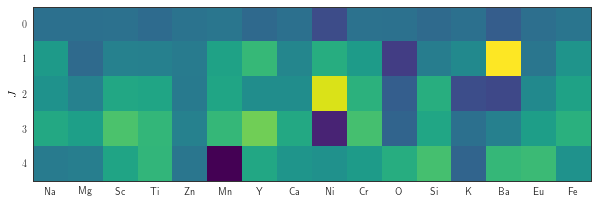

In [85]:
A = model.theta_[model.parameter_names.index("A")]
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(A.T, interpolation="nearest")
ax.set_yticks(np.arange(model.n_latent_factors))
ax.set_xticks(np.arange(D))
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)
ax.set_ylabel(r"$J$")
ax.set_xticklabels([ea.split("_")[0].title() for ea in label_names])

[Text(0,0,'Na'),
 Text(0,0,'K'),
 Text(0,0,'O'),
 Text(0,0,'Mg'),
 Text(0,0,'Si'),
 Text(0,0,'Ca'),
 Text(0,0,'Ti'),
 Text(0,0,'Sc'),
 Text(0,0,'Cr'),
 Text(0,0,'Mn'),
 Text(0,0,'Fe'),
 Text(0,0,'Ni'),
 Text(0,0,'Zn'),
 Text(0,0,'Y'),
 Text(0,0,'Ba'),
 Text(0,0,'Eu')]

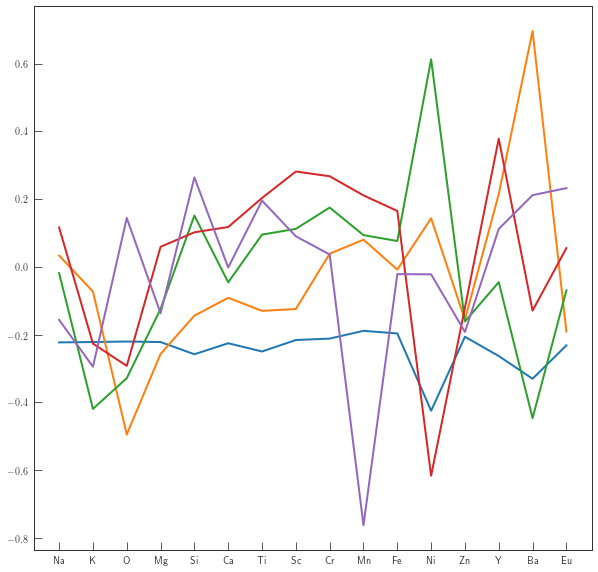

In [101]:

latex_label_name = lambda ln: ln.split("_")[0].title()
                               
A = model.theta_[model.parameter_names.index("A")]
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(A.shape[1]):
    ax.plot(np.arange(D), A.T[i][oli], "-", lw=2)
    
ax.set_xticks(np.arange(D))
ax.set_xticklabels([latex_label_name(label_names[_]) for _ in oli])


In [102]:
model.log_likelihood_

-2236.7622570079398